# Movies Recommender System
This is the second part of my Springboard Capstone Project on Movie Data Analysis and Recommendation Systems. In my first notebook ( The Story of Film ), I attempted at narrating the story of film by performing an extensive exploratory data analysis on Movies Metadata collected from TMDB. I also built two extremely minimalist predictive models to predict movie revenue and movie success and visualise which features influence the output (revenue and success respectively).
    
In this notebook, I will attempt at implementing a few recommendation algorithms (content based, popularity based and collaborative filtering) and try to build an ensemble of these models to come up with our final recommendation system. With us, we have two MovieLens datasets.     
    
The Full Dataset: Consists of 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags.   
The Small Dataset: Comprises of 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users.    
I will build a Simple Recommender using movies from the Full Dataset whereas all personalised recommender systems will make use of the small dataset (due to the computing power I possess being very limited). As a first step, I will build my simple recommender system.    

In [1]:
!pip install surprise

In [2]:
%matplotlib inline

from scipy import stats

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
import warnings; warnings.simplefilter('ignore')

# movies
## Data preprocessing
The Simple Recommender offers generalized recommnendations to every user based on movie popularity and (sometimes) genre. The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user.

The implementation of this model is extremely trivial. All we have to do is sort our movies based on ratings and popularity and display the top movies of our list. As an added step, we can pass in a genre argument to get the top movies of a particular genre.

In [3]:
import pandas as pd
import numpy as np

In [4]:
md = pd.read_csv('./data/movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
md.shape

(45466, 24)

In [6]:
# 数据规范
from ast import literal_eval

In [7]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [8]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [9]:
md.isnull().any()# 查看缺失值情况

md.loc[md['imdb_id'].isnull()==True][:5]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
8966,False,NaN,1000000,[Crime],NaN,36337,NaN,en,Delusion,"In this fast-paced, noirish road movie, a comp...",...,1991-06-07,0.0,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,She only wanted love. But money's better than ...,Delusion,False,4.8,3.0
13757,False,NaN,0,"[Comedy, Thriller]",NaN,200796,NaN,pl,Show,NaN,...,2003-03-19,0.0,NaN,[],Released,NaN,Show,False,6.3,2.0
13821,False,"{'id': 75014, 'name': 'How I Unleashed World W...",0,"[Foreign, Action, History, Comedy]",NaN,75015,NaN,pl,Jak rozpętałem drugą wojnę światową: Cz.3 - Wś...,How I Unleashed World War II tells the story o...,...,1970-04-06,0.0,73.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Released,NaN,How I Unleashed World War II Part III: Among F...,False,7.0,3.0
17382,False,NaN,2500000,"[Mystery, Thriller]",http://www.delawarepictures.net/dreamkiller/,36663,NaN,en,Dreamkiller,"A team of doctors experiment with a new, highl...",...,NaN,0.0,110.0,[],Released,Fear is the greatest killer.,Dreamkiller,False,5.0,1.0
17510,False,NaN,0,"[Drama, Romance, Foreign]",NaN,47116,NaN,en,Víťaz,Tou former boxers meet in the ring again after...,...,1979-03-09,0.0,78.0,[],Rumored,NaN,The Winner,False,0.0,0.0


In [10]:
md['imdb_id'] = md['imdb_id'].fillna('tt0000000')

md['imdb_id'].isnull().any()

md.count() #参看每列的数值数目

adult                    45466
belongs_to_collection     4494
budget                   45466
genres                   45466
homepage                  7782
id                       45466
imdb_id                  45466
original_language        45455
original_title           45466
overview                 44512
popularity               45461
poster_path              45080
production_companies     45463
production_countries     45463
release_date             45379
revenue                  45460
runtime                  45203
spoken_languages         45460
status                   45379
tagline                  20412
title                    45460
video                    45460
vote_average             45460
vote_count               45460
dtype: int64

In [11]:
# 电影类别
genre_set = set()   #设置空集合
for x in md['genres']:
    for y in range(0,len(x)-1):
        print(x[y])
        genre_set.update(x)
genre_set.discard('')  #删除''字符

Animation
Comedy
Adventure
Fantasy
Romance
Comedy
Drama
Action
Crime
Drama
Comedy
Action
Adventure
Drama
Action
Adventure
Adventure
Action
Comedy
Drama
Comedy
Family
Animation
History
Action
Drama
Drama
Crime
Crime
Comedy
Action
Comedy
Comedy
Thriller
Drama
Action
Adventure
Crime
Drama
Fantasy
Science Fiction
Drama
Comedy
Drama
Drama
Fantasy
Science Fiction
Drama
Drama
Science Fiction
Thriller
Romance
Fantasy
Drama
Comedy
History
Drama
Adventure
History
Drama
Comedy
Family
Comedy
Drama
Drama
Action
Crime
Drama
Drama
Action
Fantasy
Drama
Comedy
Drama
Crime
Mystery
Adventure
Animation
Drama
Drama
Drama
Crime
Action
Thriller
Comedy
Drama
Action
Adventure
Comedy
Comedy
Drama
Comedy
Drama
Thriller
Drama
Adventure
Family
Drama
Music
Drama
Comedy
Action
Drama
Comedy
Horror
Action
Thriller
Action
Thriller
Comedy
Drama
Drama
Drama
Comedy
Horror
Drama
Drama
Family
Drama
Drama
Romance
Drama
Action
Adventure
Comedy
Crime
Drama
Drama
Horror
Thriller
Comedy
Horror
Comedy
Drama
Action
Adventure
Drama

Adventure
Comedy
Crime
Drama
Drama
Action
Comedy
Action
Action
Adventure
Comedy
Crime
Horror
Thriller
Drama
Action
Adventure
Action
Comedy
Drama
Drama
Drama
Comedy
Romance
Action
Comedy
Music
Drama
Crime
Drama
Music
Drama
Comedy
Comedy
Comedy
Foreign
Action
Drama
Comedy
Action
Comedy
Drama
Foreign
Crime
Drama
Comedy
Comedy
Drama
Drama
Thriller
Drama
Crime
Drama
Drama
Crime
Thriller
Comedy
Comedy
Drama
History
Comedy
Comedy
Drama
Thriller
Action
Romance
Science Fiction
Action
Crime
Drama
Mystery
Comedy
Drama
Thriller
Comedy
Drama
Drama
Crime
Thriller
Animation
Comedy
Family
Action
Comedy
Action
Adventure
Family
Fantasy
Science Fiction
Drama
Action
Drama
Adventure
Horror
Action
Comedy
Thriller
Crime
Drama
Romance
Comedy
War
Drama
Drama
Drama
Drama
Comedy
Romance
Drama
Foreign
Science Fiction
Action
Drama
Comedy
Science Fiction
Comedy
Drama
Action
Romance
Comedy
Drama
Action
Crime
Drama
Romance
Fantasy
Family
Comedy
Adventure
Fantasy
Action
Thriller
Science Fiction
Drama
Drama
Comedy
Dram

Action
Action
Horror
Science Fiction
Action
Science Fiction
Action
Adventure
Drama
Horror
Science Fiction
Thriller
Adventure
Action
Romance
Science Fiction
Adventure
Drama
Adventure
Science Fiction
Action
Action
Action
Action
Adventure
Action
Drama
Action
Drama
Action
Adventure
Comedy
Action
Crime
Mystery
Drama
Romance
Comedy
Romance
Drama
Drama
Horror
Thriller
Action
Mystery
Horror
Drama
Horror
Comedy
Horror
Science Fiction
Science Fiction
Comedy
Drama
Comedy
Drama
Romance
Animation
Drama
Comedy
Horror
Thriller
Crime
Action
Drama
Drama
Drama
Music
Animation
Family
Action
Mystery
Comedy
Drama
Action
Comedy
Romance
Drama
Foreign
Drama
Comedy
Science Fiction
Crime
Drama
Crime
Comedy
Romance
Comedy
Comedy
Comedy
Drama
Comedy
Drama
Mystery
Thriller
Comedy
Crime
Comedy
Comedy
Romance
Romance
Drama
TV Movie
History
Documentary
Crime
Romance
Comedy
Drama
Comedy
Comedy
Action
Thriller
Science Fiction
Science Fiction
Action
Drama
Romance
Drama
Thriller
Comedy
Drama
Crime
Drama
Crime
Comedy
Horr

Drama
Adventure
Comedy
Fantasy
Horror
Romance
Comedy
Crime
Adventure
Action
Drama
Adventure
Action
Romance
Action
Adventure
Thriller
Adventure
Action
Comedy
Drama
Action
Romance
Action
Drama
Romance
Comedy
Crime
Adventure
Thriller
Drama
Crime
Crime
Horror
Action
Adventure
Drama
Drama
Drama
Thriller
Fantasy
Drama
Mystery
Horror
Horror
Comedy
Crime
Drama
Comedy
Drama
Western
Adventure
Family
Action
Adventure
Comedy
Music
Drama
Fantasy
Horror
Crime
Drama
Documentary
Documentary
Action
Crime
Crime
Drama
Music
Drama
Romance
Comedy
Crime
Drama
Horror
Science Fiction
Animation
Science Fiction
Fantasy
Comedy
Horror
Comedy
Science Fiction
Action
Comedy
Comedy
Horror
Comedy
Horror
Action
Comedy
Horror
Science Fiction
Action
Action
Action
Adventure
Romance
Comedy
Drama
Crime
Science Fiction
Adventure
Action
Thriller
Adventure
Action
Thriller
Action
Adventure
Action
Adventure
Comedy
Horror
Mystery
Drama
Fantasy
Drama
Horror
Action
Fantasy
Horror
Action
Adventure
Comedy
Crime
Drama
Family
Foreign
C

Comedy
Drama
Horror
Drama
Horror
Mystery
Drama
Comedy
Action
Adventure
Action
Adventure
Comedy
Action
Comedy
Thriller
Crime
Comedy
Drama
Comedy
Comedy
Drama
Adventure
Comedy
Fantasy
Adventure
Comedy
Drama
Family
Comedy
Fantasy
Horror
Romance
Comedy
Adventure
Drama
Horror
Mystery
Music
Drama
Crime
Horror
Science Fiction
Thriller
Comedy
Comedy
Drama
Foreign
War
Drama
Thriller
Crime
Western
Action
Comedy
Adventure
Comedy
Comedy
Comedy
Family
Action
Comedy
Crime
Drama
Comedy
Science Fiction
Romance
Action
Adventure
Horror
Thriller
Mystery
Music
Drama
Drama
Action
Comedy
Western
Action
Adventure
Drama
Documentary
Mystery
Drama
Fantasy
Science Fiction
Thriller
Action
Adventure
Drama
Mystery
Action
Comedy
Adventure
Animation
Action
Comedy
Horror
Drama
Mystery
Action
Comedy
Drama
Crime
Drama
Horror
Drama
History
Adventure
Drama
Comedy
Adventure
Comedy
Drama
Comedy
Crime
Mystery
Romance
Action
Horror
Drama
Comedy
Drama
Comedy
Romance
Comedy
Drama
Comedy
Comedy
Comedy
Drama
Horror
Drama
Romance


Crime
Drama
Comedy
Drama
Comedy
Drama
Comedy
Thriller
Drama
Documentary
Horror
Action
Drama
Drama
Romance
Thriller
Crime
Drama
Adventure
Action
Drama
Foreign
Comedy
Music
Drama
Drama
Family
Drama
Music
Mystery
Family
Thriller
Drama
Action
Action
Horror
Action
Comedy
War
Drama
Horror
Thriller
Crime
Mystery
Comedy
Romance
Thriller
Western
Action
Comedy
Drama
Horror
Thriller
Drama
Mystery
Adventure
Drama
Action
Thriller
Thriller
Crime
Mystery
Science Fiction
Action
Adventure
Action
Adventure
Western
Drama
Thriller
Western
Comedy
Drama
Science Fiction
Comedy
Comedy
Horror
Comedy
Fantasy
Animation
Science Fiction
Action
Drama
Comedy
Adventure
Action
Comedy
Drama
History
Mystery
Comedy
Crime
Drama
Adventure
Action
War
Drama
Drama
Music
Comedy
Horror
Romance
Comedy
Comedy
Action
Comedy
Drama
Family
Music
Comedy
Drama
Drama
Horror
Comedy
Crime
Drama
Drama
Comedy
Comedy
Comedy
Music
Drama
Action
Adventure
Comedy
Drama
Horror
Mystery
Action
Comedy
Horror
Comedy
Drama
Horror
Drama
Horror
Drama
Ac

Romance
Drama
Drama
Action
Comedy
Drama
Comedy
Drama
Fantasy
Comedy
Thriller
Drama
Adventure
Music
Comedy
Comedy
Action
Adventure
Comedy
Action
Action
Adventure
Action
Drama
Crime
Drama
Comedy
Comedy
Music
Romance
Horror
Drama
Adventure
Family
Fantasy
Romance
Drama
Drama
Drama
Comedy
History
Comedy
Drama
Drama
History
Adventure
Family
Drama
Comedy
Drama
Drama
Thriller
Drama
Drama
Drama
Drama
Romance
Thriller
Action
History
Adventure
Adventure
Drama
Thriller
Mystery
Drama
Action
Adventure
Drama
Drama
Action
Drama
Comedy
Horror
Science Fiction
Documentary
Action
Romance
Drama
History
Animation
Comedy
Crime
Crime
Drama
Action
Adventure
Crime
Drama
Drama
Drama
Action
Drama
Science Fiction
Action
Drama
Science Fiction
Action
Drama
Science Fiction
Comedy
Drama
History
Action
Romance
Comedy
Fantasy
Action
Thriller
Crime
Adventure
Drama
Adventure
Drama
Romance
Drama
Comedy
Fantasy
Thriller
Science Fiction
War
Drama
Comedy
Comedy
Mystery
Comedy
Mystery
Romance
Comedy
Crime
Comedy
Crime
Drama
My

Drama
Fantasy
Horror
Science Fiction
Crime
Drama
Mystery
Romance
Thriller
Drama
Comedy
Mystery
Drama
Drama
Comedy
Drama
Drama
Family
Fantasy
Adventure
Action
Drama
Music
Comedy
Adventure
Family
Fantasy
Science Fiction
Drama
Action
Thriller
Action
Science Fiction
Comedy
Drama
Drama
Drama
Drama
Thriller
Action
Drama
Drama
Comedy
Animation
Family
Adventure
Fantasy
Action
Comedy
Drama
Comedy
Romance
Comedy
Drama
Action
Comedy
Action
Crime
Action
Animation
Drama
Science Fiction
Comedy
Horror
Comedy
Drama
Drama
Drama
Drama
Family
Animation
Adventure
Comedy
Drama
Action
Drama
Horror
Science Fiction
Romance
Comedy
Comedy
Drama
TV Movie
Action
Adventure
Action
Crime
Action
Comedy
Animation
Action
Thriller
Science Fiction
Action
Comedy
Horror
Comedy
Drama
Action
Fantasy
Thriller
Crime
Action
Crime
Drama
Music
Action
Drama
Mystery
Horror
Comedy
Adventure
Horror
Comedy
Horror
Fantasy
Animation
Comedy
Fantasy
Crime
Drama
Horror
Fantasy
Drama
History
Animation
Adventure
Drama
Crime
Drama
Crime
Actio

Drama
Animation
Family
Adventure
Fantasy
Action
Comedy
Comedy
Romance
Horror
Drama
Drama
Comedy
Action
Adventure
Horror
Comedy
Comedy
Drama
Mystery
Action
Thriller
Comedy
Fantasy
Drama
Crime
Drama
Horror
Horror
Comedy
Comedy
Family
Comedy
Drama
Action
Drama
Drama
Comedy
Drama
Foreign
Comedy
Science Fiction
Action
Crime
Drama
Drama
History
Drama
Action
Action
Crime
Crime
Action
Thriller
Crime
Romance
Drama
Drama
Comedy
Documentary
Drama
Action
Comedy
Romance
Fantasy
Comedy
Documentary
Science Fiction
Drama
Adventure
Romance
Adventure
Action
Action
Action
Comedy
Foreign
Action
Science Fiction
Action
Comedy
Comedy
Drama
Horror
Crime
Romance
Crime
Crime
Drama
Horror
Thriller
Drama
Romance
Fantasy
Animation
Crime
Drama
Thriller
Crime
Drama
Drama
Crime
Drama
History
Music
Action
Crime
Drama
Crime
Action
Action
Adventure
Animation
Comedy
Drama
Comedy
Drama
Action
Thriller
Adventure
Drama
Action
Drama
History
Horror
Fantasy
Adventure
Animation
Comedy
Action
Action
Comedy
Crime
Action
Drama
Dra

Drama
Comedy
Romance
Family
Comedy
Music
Documentary
Action
Adventure
Comedy
Horror
Thriller
Comedy
Drama
Action
Adventure
Romance
Action
Comedy
Documentary
Drama
Fantasy
Horror
Thriller
Documentary
Drama
Fantasy
Adventure
Animation
Comedy
Drama
Music
Adventure
Fantasy
Horror
Drama
Crime
Mystery
Action
Adventure
Horror
Fantasy
Action
Thriller
Adventure
Action
Comedy
Drama
Fantasy
Comedy
Horror
Science Fiction
Thriller
Drama
Comedy
Action
Comedy
Crime
Mystery
Drama
Comedy
Thriller
Horror
Drama
Drama
Comedy
Crime
Thriller
War
Drama
Adventure
Comedy
Comedy
Horror
Science Fiction
Action
Fantasy
Action
Adventure
Horror
Action
Adventure
Science Fiction
Drama
Fantasy
Drama
Comedy
Crime
Drama
Romance
Drama
Mystery
Crime
Comedy
Family
Fantasy
Fantasy
Animation
Comedy
Adventure
Fantasy
Action
Action
Adventure
Crime
Family
Mystery
Romance
Comedy
Drama
Action
Adventure
Drama
Drama
Family
Drama
Action
Drama
Drama
Drama
Music
Romance
Drama
Action
Thriller
Crime
Mystery
Drama
Horror
Thriller
Science 

Crime
Drama
Thriller
Action
Action
Romance
Fantasy
Action
Drama
War
Action
Drama
Romance
War
Comedy
Drama
Mystery
Romance
Drama
Mystery
Horror
TV Movie
Horror
Animation
Horror
Action
Comedy
Thriller
Horror
Science Fiction
Action
Drama
Thriller
Drama
Comedy
Romance
Drama
Thriller
Drama
Fantasy
Romance
Comedy
Crime
Comedy
Drama
Comedy
Drama
Animation
Crime
Drama
Comedy
Drama
Horror
Action
Animation
Comedy
Comedy
Crime
Drama
Action
Drama
Drama
Horror
Science Fiction
Drama
History
Drama
Comedy
Comedy
Documentary
Action
Romance
Comedy
Comedy
Comedy
Drama
Horror
Action
Thriller
Family
Action
TV Movie
Drama
Action
Adventure
Drama
History
Drama
Action
Thriller
Crime
Action
Adventure
Action
History
Western
Comedy
Thriller
Action
Action
Comedy
Drama
Action
Adventure
Science Fiction
Crime
Action
Drama
Comedy
Crime
Drama
Drama
Comedy
Drama
Drama
Mystery
Action
Thriller
Action
Adventure
Action
Adventure
Comedy
Action
Horror
Comedy
Action
Science Fiction
Documentary
Drama
Comedy
Comedy
Comedy
Horror

Thriller
Adventure
Drama
War
Drama
Horror
Mystery
Drama
Science Fiction
Action
Drama
Documentary
Romance
Crime
Thriller
Drama
Science Fiction
Comedy
Drama
Thriller
Drama
Drama
Crime
Drama
Mystery
Fantasy
Adventure
Animation
Animation
Drama
History
Horror
Animation
Family
Adventure
Action
Science Fiction
Music
Drama
Comedy
Crime
Thriller
Action
Drama
Comedy
Crime
Thriller
Crime
Horror
Comedy
Action
Animation
Comedy
Comedy
Mystery
Comedy
Action
Comedy
Adventure
Fantasy
Comedy
Comedy
Drama
Horror
Science Fiction
Thriller
Drama
Drama
Action
Comedy
Adventure
Action
Drama
Action
War
Drama
History
Action
Crime
Drama
Crime
Drama
Comedy
Drama
Crime
Drama
Comedy
Documentary
Action
Animation
Comedy
Horror
Drama
History
Comedy
Crime
Action
Drama
Horror
Mystery
Comedy
Drama
Drama
Romance
Western
TV Movie
Action
Drama
Action
Animation
Family
Crime
Drama
Action
Comedy
Western
Crime
Mystery
Action
Romance
Drama
Horror
Mystery
Comedy
Drama
Drama
Drama
Documentary
Mystery
Horror
Horror
Drama
Comedy
Dram

Animation
Adventure
Animation
Mystery
Animation
Comedy
Drama
Comedy
Music
Action
Adventure
Comedy
Mystery
Fantasy
Comedy
Crime
Drama
Drama
Animation
Drama
Animation
Comedy
Drama
Romance
Drama
Animation
Drama
Action
Drama
Action
Action
Thriller
Crime
Comedy
Horror
Horror
Romance
Comedy
Drama
Drama
Comedy
Romance
Adventure
Drama
Comedy
Documentary
Fantasy
Thriller
Crime
Comedy
Comedy
Action
Comedy
Music
Fantasy
Thriller
Science Fiction
Drama
Drama
Crime
Thriller
Drama
Action
Fantasy
Thriller
Thriller
Drama
Action
Comedy
Thriller
Comedy
Horror
Drama
Action
Crime
Animation
Drama
Drama
Horror
Mystery
Documentary
Drama
Romance
TV Movie
Drama
Drama
Animation
Drama
History
Action
Adventure
Drama
Mystery
Drama
Fantasy
Thriller
Horror
Drama
Comedy
Drama
Action
Comedy
Crime
Romance
War
Fantasy
Action
Thriller
Science Fiction
Drama
Drama
Action
Drama
Action
Drama
War
Drama
History
Comedy
Drama
Mystery
Science Fiction
Comedy
Drama
Animation
Horror
Science Fiction
Comedy
Horror
Action
Drama
Drama
Fa

Crime
Drama
Horror
Science Fiction
Comedy
Action
Horror
Crime
Drama
Fantasy
Drama
Horror
Drama
Comedy
Comedy
Comedy
Action
Horror
Comedy
Comedy
Documentary
Action
Drama
Drama
Animation
Drama
Mystery
Animation
Crime
War
Crime
Drama
Mystery
Action
Crime
Fantasy
Science Fiction
Action
Drama
Drama
Thriller
Drama
Fantasy
Science Fiction
Action
Comedy
Horror
Mystery
Horror
Action
Thriller
Horror
Drama
Comedy
Comedy
History
Horror
Drama
Drama
Comedy
Science Fiction
Horror
Drama
Drama
Horror
Romance
Drama
Drama
Comedy
Action
Drama
Drama
Drama
Horror
Mystery
Horror
Comedy
Romance
Crime
Crime
Thriller
Animation
Family
Action
Mystery
Adventure
Fantasy
Drama
Comedy
Science Fiction
Thriller
Action
Adventure
Drama
Romance
Crime
Horror
Mystery
Drama
Drama
Documentary
Documentary
Western
Documentary
Drama
Thriller
Drama
Action
Family
Crime
Drama
Drama
Drama
Crime
Drama
Crime
Comedy
Horror
Action
Adventure
Animation
Horror
Thriller
Mystery
Drama
Fantasy
Science Fiction
History
Western
Drama
History
Rom

Documentary
Foreign
Comedy
Drama
Romance
Music
Documentary
Comedy
Thriller
Crime
Horror
Drama
Drama
Comedy
Comedy
Drama
Mystery
Drama
Drama
Drama
Drama
Drama
Documentary
Comedy
Drama
Romance
Science Fiction
Drama
Thriller
Comedy
Crime
Drama
Horror
Drama
Action
Thriller
Crime
Romance
Action
Comedy
Crime
Thriller
Comedy
Drama
Documentary
Drama
Drama
Drama
Horror
Drama
Animation
Horror
Action
Comedy
Thriller
Crime
Action
Drama
Comedy
Drama
Foreign
Crime
Action
Thriller
Action
Adventure
Horror
Drama
Drama
War
Drama
Documentary
Adventure
Action
Horror
Thriller
Adventure
Action
Comedy
Drama
Action
Action
Music
Comedy
Romance
Fantasy
Drama
Adventure
Drama
Family
Action
Adventure
Drama
Drama
Action
Action
Drama
Drama
Music
Romance
Drama
Documentary
Music
War
Thriller
Action
Science Fiction
Horror
Drama
Drama
Mystery
Animation
Comedy
Adventure
Family
Drama
Romance
Comedy
Romance
Horror
TV Movie
Horror
Science Fiction
Drama
Animation
Action
Mystery
Action
Thriller
Action
Foreign
Science Fiction


Horror
Comedy
Drama
Thriller
Music
Action
Horror
Action
Adventure
Drama
Fantasy
Action
Action
Comedy
Romance
Action
Horror
Drama
Action
Comedy
Drama
Documentary
Action
Drama
Adventure
Action
Drama
Action
Drama
Adventure
Crime
Documentary
Action
Drama
Fantasy
Documentary
Drama
Adventure
Horror
Thriller
Action
Animation
Mystery
Action
Drama
Horror
Thriller
Crime
Thriller
Action
TV Movie
Drama
Thriller
Drama
Romance
Crime
Drama
Crime
Thriller
Action
Comedy
Crime
Drama
Crime
Drama
Horror
Comedy
Comedy
Fantasy
Horror
Action
Drama
Adventure
Action
Horror
Drama
Documentary
Action
Comedy
War
Crime
Thriller
Adventure
Animation
Comedy
Drama
TV Movie
Drama
Romance
Horror
Action
Action
Crime
Science Fiction
Horror
Action
Thriller
Action
Adventure
Horror
Crime
Romance
Comedy
Comedy
Drama
Horror
Horror
Adventure
Animation
Animation
Horror
Drama
History
Comedy
Drama
Comedy
Horror
Science Fiction
Horror
Thriller
Thriller
Drama
Action
Drama
Comedy
Comedy
Drama
Drama
Comedy
Action
Adventure
Drama
Drama


Drama
Mystery
Horror
Thriller
Crime
Drama
Drama
Animation
Family
Animation
Animation
Family
Fantasy
Animation
Family
Adventure
Drama
Drama
Thriller
Family
Drama
Comedy
Romance
Family
Adventure
Drama
Action
Music
Drama
Action
Crime
Comedy
Action
Thriller
Thriller
Crime
Drama
Comedy
Drama
Horror
War
Crime
Action
Science Fiction
Action
Action
Science Fiction
Action
Crime
Drama
Drama
Drama
Drama
Romance
Romance
Horror
Action
Comedy
Comedy
Comedy
Romance
Action
Adventure
Drama
Drama
Adventure
Drama
Romance
Music
Animation
Family
Drama
Thriller
Action
Drama
Documentary
Foreign
Comedy
Horror
Drama
Horror
Thriller
Drama
Family
Adventure
Thriller
Action
Drama
Action
Comedy
War
Horror
Drama
Adventure
Drama
Action
Action
Drama
Thriller
Comedy
Action
Drama
War
History
Thriller
Comedy
Crime
Drama
Comedy
Music
Adventure
Drama
Animation
Crime
Drama
Mystery
Action
Drama
Romance
Comedy
Horror
Drama
Drama
Horror
Action
Action
Crime
Adventure
Drama
Action
Thriller
Crime
Action
Comedy
Horror
Mystery
Roman

Adventure
Horror
Fantasy
Drama
Action
Comedy
Drama
Comedy
Music
Horror
Drama
Drama
Romance
Action
Family
Foreign
Drama
Foreign
War
Drama
History
Horror
Romance
Adventure
Action
War
Documentary
Comedy
Crime
Thriller
Action
Mystery
Thriller
Drama
Romance
Drama
Crime
Drama
Romance
Drama
Action
Science Fiction
History
Adventure
Animation
Comedy
Comedy
Drama
Fantasy
Family
Crime
Family
Crime
Drama
Crime
Drama
Mystery
Romance
Romance
Horror
Horror
Comedy
Drama
Science Fiction
Crime
Mystery
Drama
Drama
Foreign
Drama
Action
Crime
Drama
Comedy
Drama
Drama
Drama
War
Animation
Family
Crime
Action
Documentary
Action
Romance
Romance
Drama
Drama
Romance
Comedy
Drama
Action
Adventure
Fantasy
Action
Drama
Drama
Drama
Action
Adventure
Drama
Drama
Science Fiction
Adventure
Horror
Action
Action
Adventure
Fantasy
Romance
Crime
Crime
Drama
Mystery
Horror
Drama
Drama
Drama
Action
Crime
Comedy
Horror
Mystery
Adventure
Action
Adventure
Comedy
Crime
TV Movie
Drama
Science Fiction
War
Drama
Drama
Drama
TV Movie

Drama
Action
Thriller
Music
Romance
Family
Action
Drama
Drama
Thriller
Action
Romance
Action
Drama
Crime
Action
Action
Comedy
Horror
Romance
Action
Adventure
Drama
Horror
Thriller
Drama
Comedy
Comedy
Science Fiction
Thriller
Horror
Action
Adventure
Action
Adventure
TV Movie
Romance
Drama
Comedy
Drama
Crime
Horror
Horror
Mystery
Drama
Horror
Mystery
Horror
Horror
Music
Crime
Comedy
Documentary
Comedy
Comedy
Horror
Action
Drama
Mystery
Drama
Adventure
Drama
Drama
Action
Action
Drama
Action
Drama
Action
Crime
Crime
Horror
Western
Comedy
Drama
Adventure
Thriller
Fantasy
Science Fiction
Comedy
Family
Comedy
Drama
Fantasy
Animation
Adventure
Drama
Thriller
Animation
Romance
Family
Family
Adventure
Animation
Comedy
Family
Animation
Comedy
Family
Animation
Comedy
Adventure
Comedy
Animation
Horror
Animation
Comedy
Action
Comedy
Drama
Animation
Animation
War
Comedy
Animation
Animation
Comedy
Drama
Science Fiction
Thriller
Drama
Thriller
Comedy
Drama
Horror
Romance
Action
Romance
Drama
Comedy
Ani

Action
Thriller
Comedy
Romance
Action
Comedy
Horror
Romance
Comedy
Comedy
Comedy
Science Fiction
Animation
Foreign
Action
Adventure
Horror
Drama
Crime
Drama
Horror
Thriller
Comedy
Foreign
Crime
Drama
Horror
Drama
Comedy
Romance
TV Movie
Crime
Mystery
Thriller
TV Movie
Thriller
Horror
Thriller
TV Movie
Crime
Mystery
TV Movie
Drama
Drama
TV Movie
Drama
Mystery
Thriller
Thriller
Drama
Drama
Mystery
Drama
TV Movie
Thriller
Drama
Drama
Drama
Mystery
Drama
Drama
TV Movie
Drama
Thriller
Crime
Drama
Horror
TV Movie
Drama
Mystery
Fantasy
Animation
Action
Crime
Drama
Mystery
Thriller
Thriller
War
Adventure
Action
Drama
Thriller
Drama
Horror
Horror
Thriller
Action
Crime
TV Movie
Drama
Thriller
Comedy
Drama
Drama
Drama
History
Action
Comedy
Drama
Drama
Drama
Thriller
Drama
Comedy
Drama
Foreign
Drama
Romance
Documentary
Drama
Drama
Drama
Action
Thriller
Drama
Action
War
Drama
Drama
Adventure
Crime
Mystery
Drama
Comedy
Comedy
Thriller
Thriller
Horror
Thriller
Mystery
Comedy
Drama
Action
Action
Drama

Science Fiction
Family
Comedy
Drama
Music
Comedy
Comedy
Drama
Thriller
Drama
Family
Adventure
Family
Action
Science Fiction
Action
Drama
Drama
Music
Horror
Action
Adventure
Crime
Crime
Comedy
Family
Mystery
Comedy
Comedy
Drama
Drama
Foreign
Drama
Mystery
Action
Drama
Thriller
Action
Horror
Drama
Horror
Adventure
Comedy
Family
Science Fiction
Action
Drama
Romance
Drama
Adventure
Animation
Crime
Thriller
Mystery
Drama
Romance
Western
Action
Crime
Crime
History
Comedy
Fantasy
Family
History
Crime
Action
Adventure
Animation
Adventure
Comedy
Action
Action
Comedy
Fantasy
Drama
Thriller
Drama
Drama
History
Crime
Documentary
Horror
Thriller
Action
Adventure
Adventure
Thriller
History
Adventure
Crime
War
Drama
Romance
Drama
Mystery
Romance
Drama
Comedy
Drama
Romance
Action
Drama
Family
Fantasy
Drama
Drama
Crime
Drama
Mystery
Drama
Foreign
Romance
Action
Comedy
Thriller
Drama
Comedy
Thriller
Action
Action
Horror
War
Family
Music
Thriller
Drama
TV Movie
Crime
Family
Comedy
Romance
Comedy
Drama
Dr

Science Fiction
Action
Romance
Crime
Action
Science Fiction
Music
Action
Crime
Action
Comedy
Romance
Science Fiction
Thriller
Drama
Fantasy
Drama
Crime
Action
Action
Thriller
Action
Animation
Science Fiction
Mystery
Documentary
Thriller
Documentary
Family
Fantasy
Horror
Romance
Thriller
Comedy
Romance
Drama
Drama
Action
Comedy
Drama
Romance
Drama
Thriller
Horror
Romance
Comedy
Comedy
Romance
Action
Drama
Drama
Drama
Romance
Drama
Comedy
Horror
Thriller
Foreign
Drama
Drama
Romance
Drama
Documentary
Mystery
Family
Adventure
Romance
Horror
Comedy
Comedy
Action
Drama
Comedy
TV Movie
Action
Horror
Odyssey Media
Pulser Productions
Rogue State
War
Documentary
Drama
Fantasy
Drama
Fantasy
Science Fiction
Comedy
Action
Science Fiction
Comedy
Crime
Romance
Action
Drama
Science Fiction
Action
Drama
Comedy
Action
Action
Thriller
Romance
Drama
Action
Crime
Drama
Drama
Drama
Foreign
Horror
Romance
Thriller
Romance
Drama
Comedy
Comedy
Drama
Horror
Thriller
Drama
Action
Adventure
Thriller
Family
Comedy

History
Horror
Comedy
Crime
Thriller
Action
Thriller
Horror
Drama
Documentary
Drama
Animation
Drama
Action
Horror
Drama
Horror
Drama
Thriller
Horror
Action
Drama
Comedy
Comedy
Family
Fantasy
Comedy
Comedy
Drama
Romance
Crime
Drama
Comedy
Drama
Mystery
Romance
Animation
Comedy
Comedy
Family
Romance
Comedy
Drama
Documentary
Comedy
Comedy
Comedy
Action
Action
Comedy
Drama
Drama
Crime
Horror
Foreign
Mystery
Science Fiction
Action
Science Fiction
Animation
Action
Animation
Mystery
Romance
Action
Comedy
Horror
Drama
Romance
Romance
Comedy
Fantasy
Comedy
Horror
Drama
Comedy
Romance
Music
Romance
Drama
Horror
Mystery
Thriller
Thriller
Music
Science Fiction
Animation
Action
Comedy
Drama
Drama
Thriller
Action
Crime
Drama
Comedy
Drama
Adventure
Animation
Comedy
Romance
Comedy
Music
Comedy
Drama
Comedy
Drama
Comedy
Romance
Horror
War
Action
Drama
History
Family
Drama
Romance
Documentary
Comedy
Drama
Adventure
Family
Adventure
Fantasy
Drama
Drama
Thriller
Drama
Comedy
Drama
Action
Comedy
Comedy
Act

Drama
Comedy
Crime
Romance
Documentary
Comedy
Adventure
Comedy
Drama
Mystery
Drama
Crime
Action
Comedy
Crime
Drama
Drama
Drama
Thriller
Comedy
Drama
Mystery
Drama
Horror
Documentary
Documentary
Action
History
Romance
Drama
Drama
Drama
Science Fiction
Drama
Family
Horror
Science Fiction
Music
Comedy
Horror
Animation
Comedy
Animation
Mystery
Crime
Mystery
Crime
Drama
Drama
Drama
Science Fiction
Adventure
Adventure
Mystery
Action
Drama
Family
Animation
Romance
Romance
Drama
TV Movie
Drama
Fantasy
Horror
Drama
Action
Drama
Animation
Crime
Documentary
Drama
Documentary
Crime
Adventure
Horror
Comedy
Family
Comedy
Comedy
Romance
Crime
Drama
Horror
Mystery
Crime
Horror
Documentary
Thriller
Action
Crime
Drama
Drama
Thriller
Drama
Comedy
Drama
Family
Fantasy
Drama
Fantasy
Drama
Science Fiction
Thriller
Drama
Science Fiction
Comedy
Horror
Science Fiction
Drama
Horror
Comedy
Thriller
Comedy
Comedy
History
Drama
Animation
Family
Fantasy
Adventure
Animation
Comedy
Adventure
Fantasy
Horror
Documentar

Drama
Drama
Horror
TV Movie
Action
Adventure
Horror
Science Fiction
Action
Comedy
Crime
Drama
Horror
Thriller
Documentary
Family
Drama
Drama
Comedy
Horror
Comedy
Music
Comedy
Comedy
Romance
Thriller
Science Fiction
Crime
Drama
Mystery
Action
Animation
Fantasy
Animation
Action
Adventure
Drama
Horror
Drama
Drama
Comedy
Crime
Crime
Drama
Comedy
Comedy
Action
Crime
Comedy
Action
Romance
Drama
Action
Science Fiction
Fantasy
Romance
Thriller
Animation
Action
Drama
Crime
Drama
Thriller
Drama
Adventure
Drama
Crime
Mystery
Mystery
Fantasy
Action
Drama
Action
Adventure
Horror
Action
Adventure
Family
Action
Thriller
Fantasy
Horror
Science Fiction
Thriller
Action
Adventure
Comedy
Horror
Science Fiction
Science Fiction
Action
Drama
Horror
Mystery
Animation
Comedy
Adventure
Animation
Action
Action
Comedy
Drama
Action
Thriller
Adventure
Drama
Horror
Mystery
Horror
Action
Mystery
Comedy
Romance
Drama
Music
Thriller
TV Movie
Drama
Music
Romance
Adventure
History
Documentary
Horror
Mystery
Drama
Fantasy

Drama
Comedy
Comedy
Adventure
Comedy
Drama
Drama
Action
Comedy
Action
Drama
Animation
Comedy
TV Movie
Family
Action
Comedy
Music
Comedy
Drama
Comedy
Documentary
Action
Comedy
Animation
Horror
Comedy
Comedy
Drama
Romance
Science Fiction
Comedy
Drama
Adventure
Comedy
Crime
Comedy
Documentary
Drama
Science Fiction
Drama
Comedy
Fantasy
Music
Comedy
Drama
Comedy
Comedy
Drama
Fantasy
Adventure
Family
Music
Romance
Drama
Drama
Comedy
Documentary
Comedy
Comedy
Comedy
Drama
Horror
Comedy
Crime
Drama
Thriller
Comedy
Fantasy
Fantasy
Horror
Action
Comedy
Science Fiction
Foreign
Western
Action
Adventure
Drama
Drama
Horror
Comedy
Horror
Comedy
Action
Horror
Action
Science Fiction
Horror
Fantasy
Action
Comedy
Romance
Adventure
Drama
Action
Thriller
Comedy
Fantasy
Comedy
Romance
Comedy
Documentary
Romance
Horror
Thriller
Action
Action
Adventure
Comedy
Horror
TV Movie
Drama
Drama
Romance
Crime
Mystery
Drama
History
Romance
Drama
Comedy
Comedy
Drama
Romance
Drama
Romance
Romance
Crime
Comedy
Action
Dram

In [12]:
genre_set

{'Action',
 'Adventure',
 'Animation',
 'Aniplex',
 'BROSTA TV',
 'Carousel Productions',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'GoHands',
 'History',
 'Horror',
 'Mardock Scramble Production Committee',
 'Music',
 'Mystery',
 'Odyssey Media',
 'Pulser Productions',
 'Rogue State',
 'Romance',
 'Science Fiction',
 'Sentai Filmworks',
 'TV Movie',
 'Telescene Film Group Productions',
 'The Cartel',
 'Thriller',
 'Vision View Entertainment',
 'War',
 'Western'}

In [13]:
#对各种电影风格genre，进行one-hot编码
genre_df = pd.DataFrame()  # 创建空的数据框
for genre in genre_set:
    #如果一个值中包含特定内容，则编码为1，否则编码为0
    genre_df[genre] = md['genres'].str.contains(genre).map(lambda x:1 if x else 0)

In [14]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [15]:
genre_df['year']=md['year']

In [16]:
#将genre_df按year分组，计算每组之和。groupby之后，year列通过默认参数as_index=True自动转化为df.index
genre_by_year = genre_df.groupby('year').sum()  
genresum_by_year = genre_by_year.sum().sort_values(ascending=False)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

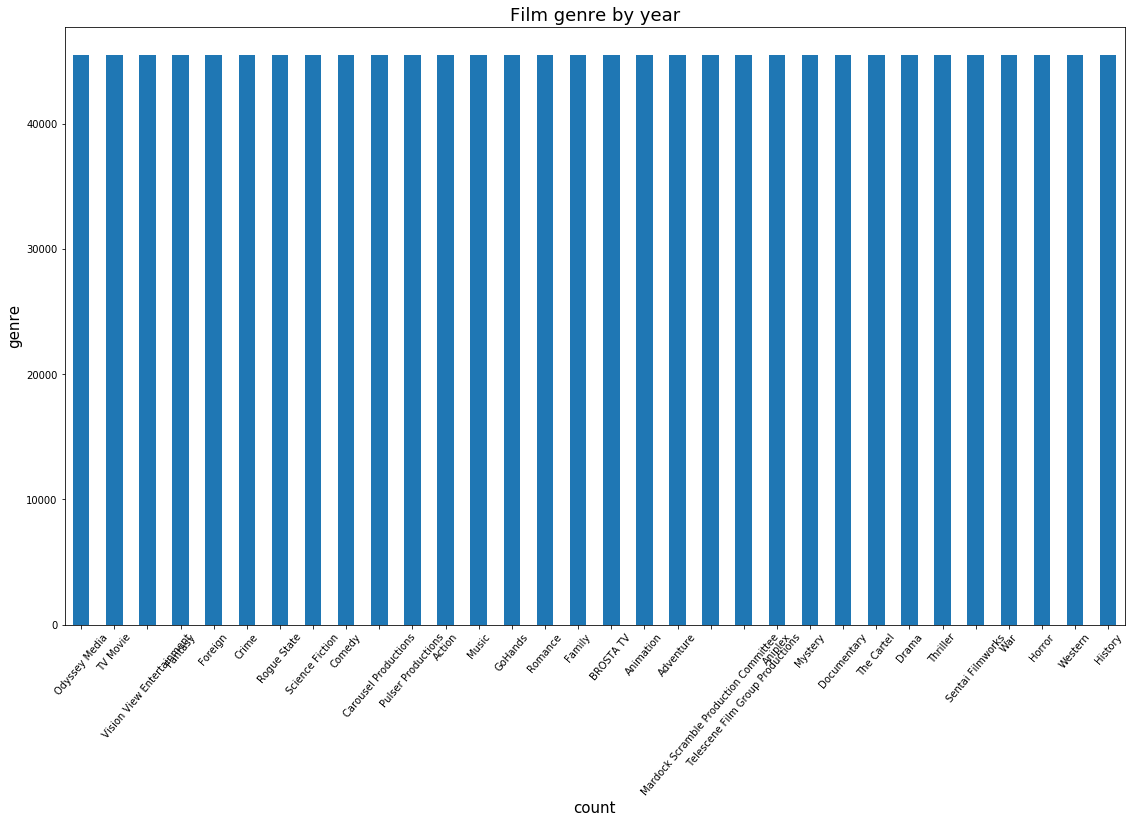

In [18]:
#计算每个风格genre的电影总数目，并降序排列，再可视化
fig = plt.figure(figsize=(19,11))   #设置画图框的大小
ax = plt.subplot(1,1,1)     #设置框的位置
ax = genresum_by_year.plot.bar()

plt.xticks(rotation=50)
plt.title('Film genre by year', fontsize=18)    #设置标题的字体大小，标题名
plt.xlabel('count', fontsize=15)    #X轴名及轴名大小
plt.ylabel('genre', fontsize=15)    #y轴名及轴名大小
plt.show()  #可以用查看数据画的图。
#保存图片
fig.savefig('film genre by year.png',dpi=600)

In [19]:
#筛选出电影风格TOP8
genre_by_year = genre_by_year[['Drama','Comedy','Thriller','Romance',
                               'Adventure','Crime', 'Science Fiction',
                               'Horror']].loc[:,:]
year_min = md['year'].min()   #最小年份
year_max = md['year'].max()   #最大年份

In [20]:
year_min

'1874'

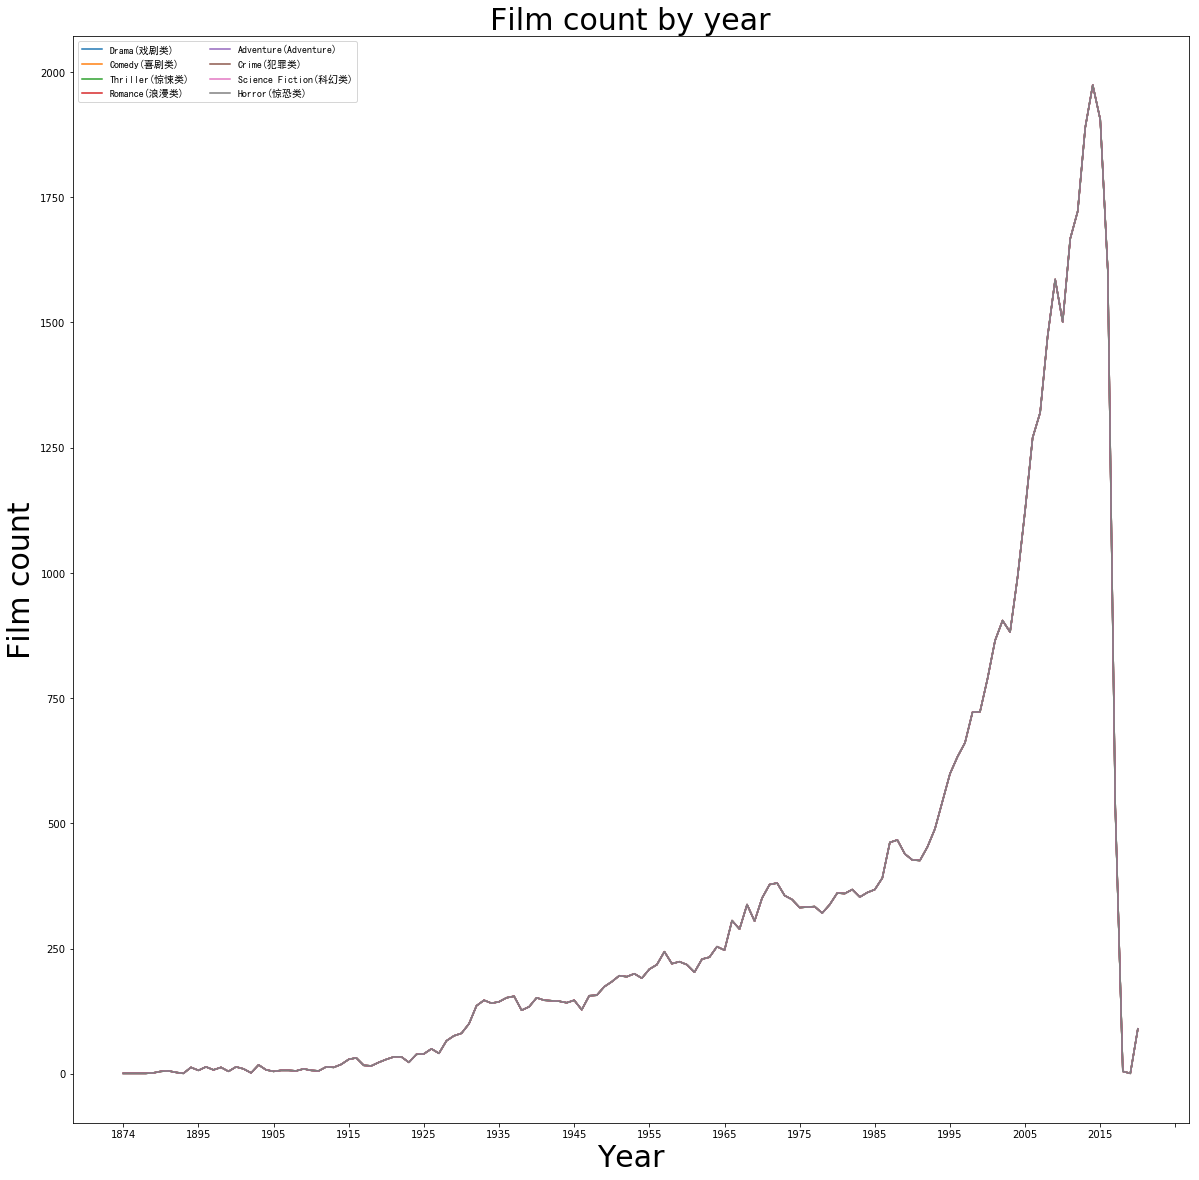

In [21]:
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(1,1,1)
plt.plot(genre_by_year)
plt.xlabel('Year', fontsize=30)
plt.ylabel('Film count', fontsize=30)
plt.title('Film count by year', fontsize=30)
plt.xticks(range(0,150,10))  #横坐标每隔10年一个刻度
#设置表格用什么字体
font = {
    'family' : 'SimHei'
}

import matplotlib
matplotlib.rc('font', **font)
plt.legend(['Drama(戏剧类)','Comedy(喜剧类)','Thriller(惊悚类)','Romance(浪漫类)',
                               'Adventure(Adventure)','Crime(犯罪类)', 'Science Fiction(科幻类)',
                               'Horror(惊恐类)'], loc='best',ncol=2) #设置说明标签
fig.savefig('film count by year.png',dpi=200)

In [22]:
popular_data=pd.DataFrame()
popular_data['id']=md['id']
popular_data['title']=md['title']
popular_data['year']=md['year']
popular_data['popularity']=md['popularity']
popular_data.head()

,id,title,year,popularity
0,862,Toy Story,1995,21.9469
1,8844,Jumanji,1995,17.0155
2,15602,Grumpier Old Men,1995,11.7129
3,31357,Waiting to Exhale,1995,3.85949
4,11862,Father of the Bride Part II,1995,8.38752


In [23]:
popular_data=pd.DataFrame()
popular_data['id']=md['id']
popular_data['title']=md['title']
popular_data['year']=md['year']
popular_data['vote_average']=md['vote_average']
popular_data.head()

,id,title,year,vote_average
0,862,Toy Story,1995,7.7
1,8844,Jumanji,1995,6.9
2,15602,Grumpier Old Men,1995,6.5
3,31357,Waiting to Exhale,1995,6.1
4,11862,Father of the Bride Part II,1995,5.7


In [24]:
popular_data.sort_values(by='vote_average',ascending=False).head(10)

,id,title,year,vote_average
21642,320849,Ice Age Columbus: Who Were the First Americans?,2005,10.0
15710,96451,If God Is Willing and da Creek Don't Rise,2010,10.0
22396,72123,Meat the Truth,2008,10.0
22395,230864,Marvin Hamlisch: What He Did For Love,2013,10.0
35343,140595,Elaine Stritch: At Liberty,2002,10.0
186,58372,Reckless,1995,10.0
45047,405446,The Human Surge,2016,10.0
22377,163795,The Guide,2011,10.0
22346,388182,هیچ کجا هیچ کس,2013,10.0
1634,64562,Other Voices Other Rooms,1995,10.0


# TMDb Rating

I use the TMDB Ratings to come up with our Top Movies Chart. I will use IMDB's weighted rating formula to construct my chart. Mathematically, it is represented as follows:

Weighted Rating (WR) = (vv+m.R)+(mv+m.C)(vv+m.R)+(mv+m.C)
where,
   
v is the number of votes for the movie  
m is the minimum votes required to be listed in the chart    
R is the average rating of the movie   
C is the mean vote across the whole report    
The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.      

I will build our overall Top 250 Chart and will define a function to build charts for a particular genre. Let's begin!      

In [25]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()#平均票数
C

5.244896612406511

In [26]:
m = vote_counts.quantile(0.95)#进入IMDb top250 需要的最小投票数
m

434.0

In [27]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [28]:
md['year'].head()

0    1995
1    1995
2    1995
3    1995
4    1995
Name: year, dtype: object

In [29]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [30]:
qualified.head()

,title,year,vote_count,vote_average,popularity,genres
0,Toy Story,1995,5415,7,21.9469,"[Animation, Comedy, Family]"
1,Jumanji,1995,2413,6,17.0155,"[Adventure, Fantasy, Family]"
5,Heat,1995,1886,7,17.9249,"[Action, Crime, Drama, Thriller]"
9,GoldenEye,1995,1194,6,14.686,"[Adventure, Action, Thriller]"
15,Casino,1995,1343,7,10.1374,"[Drama, Crime]"


Therefore, to qualify to be considered for the chart, a movie has to have at least 434 votes on TMDB. We also see that the average rating for a movie on TMDB is 5.244 on a scale of 10. 2274 Movies qualify to be on our chart.

In [31]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [32]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [33]:
qualified.head()

,title,year,vote_count,vote_average,popularity,genres,wr
0,Toy Story,1995,5415,7,21.9469,"[Animation, Comedy, Family]",6.869770
1,Jumanji,1995,2413,6,17.0155,"[Adventure, Fantasy, Family]",5.884891
5,Heat,1995,1886,7,17.9249,"[Action, Crime, Drama, Thriller]",6.671675
9,GoldenEye,1995,1194,6,14.686,"[Adventure, Action, Thriller]",5.798701
15,Casino,1995,1343,7,10.1374,"[Drama, Crime]",6.571348


In [34]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

Top Movies

In [35]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.2135,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.8696,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.95,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.6454,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.3072,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.4235,"[Adventure, Fantasy, Action]",7.851924


We see that three Christopher Nolan Films, Inception, The Dark Knight and Interstellar occur at the very top of our chart. The chart also indicates a strong bias of TMDB Users towards particular genres and directors.       

Let us now construct our function that builds charts for particular genres. For this, we will use relax our default conditions to the 85th percentile instead of 95.

In [36]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [37]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


In [38]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

Let us see our method in action by displaying the Top 15 Romance Movies (Romance almost didn't feature at all in our Generic Top Chart despite being one of the most popular movie genres).

Top Romance Movies

In [39]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457,8.565285
351,Forrest Gump,1994,8147,8,48.3072,7.971357
876,Vertigo,1958,1162,8,18.2082,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.8451,7.745154
1132,Cinema Paradiso,1988,834,8,14.177,7.744878
19901,Paperman,2012,734,8,7.19863,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.9943,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


The top romance movie according to our metrics is Bollywood's Dilwale Dulhania Le Jayenge. This Shahrukh Khan starrer also happens to be one of my personal favorites.

# Content Based Recommender  
The recommender we built in the previous section suffers some severe limitations. For one, it gives the same recommendation to everyone, regardless of the user's personal taste. If a person who loves romantic movies (and hates action) were to look at our Top 15 Chart, s/he wouldn't probably like most of the movies. If s/he were to go one step further and look at our charts by genre, s/he wouldn't still be getting the best recommendations.

For instance, consider a person who loves Dilwale Dulhania Le Jayenge, My Name is Khan and Kabhi Khushi Kabhi Gham. One inference we can obtain is that the person loves the actor Shahrukh Khan and the director Karan Johar. Even if s/he were to access the romance chart, s/he wouldn't find these as the top recommendations.

To personalise our recommendations more, I am going to build an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. Since we will be using movie metadata (or content) to build this engine, this also known as Content Based Filtering.

I will build two Content Based Recommenders based on:

Movie Overviews and Taglines
Movie Cast, Crew, Keywords and Genre
Also, as mentioned in the introduction, I will be using a subset of all the movies available to us due to limiting computing power available to me.

In [40]:
links_small = pd.read_csv('./data/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [41]:
md = md.drop([19730, 29503, 35587])

In [42]:
#Check EDA Notebook for how and why I got these indices.
md['id'] = md['id'].astype('int')

In [43]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

We have 9099 movies avaiable in our small movies metadata dataset which is 5 times smaller than our original dataset of 45000 movies.

Movie Description Based Recommender
Let us first try to build a recommender using movie descriptions and taglines. We do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively.

In [44]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [46]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [47]:
tfidf_matrix.shape

(9099, 268124)

Cosine Similarity
I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

cosine(x,y)=x.y⊺||x||.||y||cosine(x,y)=x.y⊺||x||.||y||
Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [48]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [49]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

We now have a pairwise cosine similarity matrix for all the movies in our dataset. The next step is to write a function that returns the 30 most similar movies based on the cosine similarity score.

In [50]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [51]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

We're all set. Let us now try and get the top recommendations for a few movies and see how good the recommendations are.

In [52]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [53]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

We see that for The Dark Knight, our system is able to identify it as a Batman film and subsequently recommend other Batman films as its top recommendations. But unfortunately, that is all this system can do at the moment. This is not of much use to most people as it doesn't take into considerations very important features such as cast, crew, director and genre, which determine the rating and the popularity of a movie. Someone who liked The Dark Knight probably likes it more because of Nolan and would hate Batman Forever and every other substandard movie in the Batman Franchise.

Therefore, we are going to use much more suggestive metadata than Overview and Tagline. In the next subsection, we will build a more sophisticated recommender that takes genre, keywords, cast and crew into consideration.

## Metadata Based Recommender  
To build our standard metadata based content recommender, we will need to merge our current dataset with the crew and the keyword datasets. Let us prepare this data as our first step.

In [80]:
credits = pd.read_csv('./data/credits.csv')
keywords = pd.read_csv('./data/keywords.csv')

In [81]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [82]:
md.shape

(45463, 25)

In [83]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [84]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 28)

We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:

Crew: From the crew, we will only pick the director as our feature since the others don't contribute that much to the feel of the movie.
Cast: Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list.

In [85]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [86]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [87]:
smd['director'] = smd['crew'].apply(get_director)

In [88]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [89]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

My approach to building the recommender is going to be extremely hacky. What I plan on doing is creating a metadata dump for every movie which consists of genres, director, main actors and keywords. I then use a Count Vectorizer to create our count matrix as we did in the Description Recommender. The remaining steps are similar to what we did earlier: we calculate the cosine similarities and return movies that are most similar.
  
These are steps I follow in the preparation of my genres and credits data:
   
Strip Spaces and Convert to Lowercase from all our features. This way, our engine will not confuse between Johnny Depp and Johnny Galecki.
Mention Director 3 times to give it more weight relative to the entire cast.

In [90]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [91]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

Keywords   
We will do a small amount of pre-processing of our keywords before putting them to any use. As a first step, we calculate the frequenct counts of every keyword that appears in the dataset.   

In [92]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [93]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

Keywords occur in frequencies ranging from 1 to 610. We do not have any use for keywords that occur only once. Therefore, these can be safely removed. Finally, we will convert every word to its stem so that words such as Dogs and Dog are considered the same.  

In [94]:
s = s[s > 1]

In [95]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [96]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [97]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [98]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [99]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [100]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [101]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

We will reuse the get_recommendations function that we had written earlier. Since our cosine similarity scores have changed, we expect it to give us different (and probably better) results. Let us check for The Dark Knight again and see what recommendations I get this time around.    

In [102]:
get_recommendations('The Dark Knight').head(10)

8031         The Dark Knight Rises
6218                 Batman Begins
6623                  The Prestige
2085                     Following
7648                     Inception
4145                      Insomnia
3381                       Memento
8613                  Interstellar
7659    Batman: Under the Red Hood
1134                Batman Returns
Name: title, dtype: object

I am much more satisfied with the results I get this time around. The recommendations seem to have recognized other Christopher Nolan movies (due to the high weightage given to director) and put them as top recommendations. I enjoyed watching The Dark Knight as well as some of the other ones in the list including Batman Begins, The Prestige and The Dark Knight Rises.    

We can of course experiment on this engine by trying out different weights for our features (directors, actors, genres), limiting the number of keywords that can be used in the soup, weighing genres based on their frequency, only showing movies with the same languages, etc.    

Let me also get recommendations for another movie, Mean Girls which happens to be my girlfriend's favorite movie.    

In [103]:
get_recommendations('Mean Girls').head(10)

3319               Head Over Heels
4763                 Freaky Friday
1329              The House of Yes
6277              Just Like Heaven
7905         Mr. Popper's Penguins
7332    Ghosts of Girlfriends Past
6959     The Spiderwick Chronicles
8883                      The DUFF
6698         It's a Boy Girl Thing
7377       I Love You, Beth Cooper
Name: title, dtype: object

## Popularity and Ratings
One thing that we notice about our recommendation system is that it recommends movies regardless of ratings and popularity. It is true that Batman and Robin has a lot of similar characters as compared to The Dark Knight but it was a terrible movie that shouldn't be recommended to anyone.
        
Therefore, we will add a mechanism to remove bad movies and return movies which are popular and have had a good critical response.
  
I will take the top 25 movies based on similarity scores and calculate the vote of the 60th percentile movie. Then, using this as the value of mm, we will calculate the weighted rating of each movie using IMDB's formula like we did in the Simple Recommender section.

In [104]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [105]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.917588
8613,Interstellar,11187,8,2014,7.897107
6623,The Prestige,4510,8,2006,7.758148
3381,Memento,4168,8,2000,7.740175
8031,The Dark Knight Rises,9263,7,2012,6.921448
6218,Batman Begins,7511,7,2005,6.904127
1134,Batman Returns,1706,6,1992,5.846862
132,Batman Forever,1529,5,1995,5.054144
9024,Batman v Superman: Dawn of Justice,7189,5,2016,5.013943
1260,Batman & Robin,1447,4,1997,4.287233


Let me also get the recommendations for Mean Girls, my girlfriend's favorite movie.

In [106]:
improved_recommendations('Mean Girls')

,title,vote_count,vote_average,year,wr
1547,The Breakfast Club,2189,7,1985,6.709602
390,Dazed and Confused,588,7,1993,6.254682
8883,The DUFF,1372,6,2015,5.818541
3712,The Princess Diaries,1063,6,2001,5.781086
4763,Freaky Friday,919,6,2003,5.757786
6277,Just Like Heaven,595,6,2005,5.681521
6959,The Spiderwick Chronicles,593,6,2008,5.680901
7494,American Pie Presents: The Book of Love,454,5,2009,5.119690
7332,Ghosts of Girlfriends Past,716,5,2009,5.092422
7905,Mr. Popper's Penguins,775,5,2011,5.087912


Unfortunately, Batman and Robin does not disappear from our recommendation list. This is probably due to the fact that it is rated a 4, which is only slightly below average on TMDB. It certainly doesn't deserve a 4 when amazing movies like The Dark Knight Rises has only a 7. However, there is nothing much we can do about this. Therefore, we will conclude our Content Based Recommender section here and come back to it when we build a hybrid engine.

## Collaborative Filtering   
Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who s/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

I will not be implementing Collaborative Filtering from scratch. Instead, I will use the Surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.

In [55]:
reader = Reader()

In [60]:
ratings = pd.read_csv('./data/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [64]:
from surprise import accuracy
from surprise.model_selection import KFold

In [65]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
# data.split(n_folds=5)
kf = KFold(n_splits=5)

In [66]:
svd = SVD()
# evaluate(svd, data, measures=['RMSE', 'MAE'])

In [68]:
mean_rmse=0
for trainset, testset in kf.split(data):
    svd.fit(trainset)
    predictions = svd.test(testset)
    mean_rmse=accuracy.rmse(predictions, verbose=True) + mean_rmse
print("Mean RMSE:", mean_rmse/5)

RMSE: 0.8850
RMSE: 0.9073
RMSE: 0.8957
RMSE: 0.8990
RMSE: 0.8980
Mean RMSE: 0.8970060921170745


We get a mean Root Mean Sqaure Error of 0.8963 which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [70]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Let us pick user 5000 and check the ratings s/he has given.

In [71]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [112]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.7763607323404074, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of 2.686. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## Hybrid Recommender

In this section, I will try to build a simple hybrid recommender that brings together techniques we have implemented in the content based and collaborative filter based engines. This is how it will work:
    
Input: User ID and the Title of a Movie     
Output: Similar movies sorted on the basis of expected ratings by that particular user.   

In [73]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [75]:
id_map = pd.read_csv('./data/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [76]:
indices_map = id_map.set_index('id')

In [77]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [119]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,year,id,est
974,Aliens,3282.0,7.7,1986,679,3.237042
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.118893
1011,The Terminator,4208.0,7.4,1984,218,3.082858
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,3.048264
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,2.992104
2014,Fantastic Planet,140.0,7.6,1973,16306,2.855258
3060,Sinbad and the Eye of the Tiger,39.0,6.3,1977,11940,2.825683
1621,Darby O'Gill and the Little People,35.0,6.7,1959,18887,2.751730
344,True Lies,1138.0,6.8,1994,36955,2.690083
922,The Abyss,822.0,7.1,1989,2756,2.660450


In [79]:
hybrid(500, 'Avatar')

,title,vote_count,vote_average,year,id,est
975,A Grand Day Out,199.0,7.4,1990,530,3.725034
6105,A Trip to the Moon,314.0,7.9,1902,775,3.587036
7763,Hanna,1284.0,6.5,2011,50456,3.295807
4804,Avalon,93.0,6.8,2001,10881,3.262079
5044,The Men,18.0,6.5,1950,1882,3.152818
3360,The Dish,62.0,6.6,2000,5257,3.130268
7050,Pride and Glory,243.0,6.3,2008,13150,3.087815
4506,Tears of the Sun,582.0,6.4,2003,9567,3.045063
1898,A Simple Plan,191.0,6.9,1998,10223,3.038398
7587,The American,488.0,5.8,2010,27579,2.993416


We see that for our hybrid recommender, we get different recommendations for different users although the movie is the same. Hence, our recommendations are more personalized and tailored towards particular users.